# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using ForwardDiff
using Optim
using RxInfer
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("./NARXAgents.jl"); using .NARXAgents
includet("./Pendulums.jl"); using .Pendulums

In [2]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.2
sys_mnoise_sd = 1e-3
sys_ulims = (-50.,50.)
Δt = 0.1

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.0004126070062665368, 0.0, (-50.0, 50.0), 0.1, 2.0, 0.5, 0.2, 0.001)

In [3]:
N = 300
tsteps = range(0.0, step=Δt, length=N)

0.0:0.1:29.9

In [4]:
# Inputs
A  = rand(10)*200 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [5]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

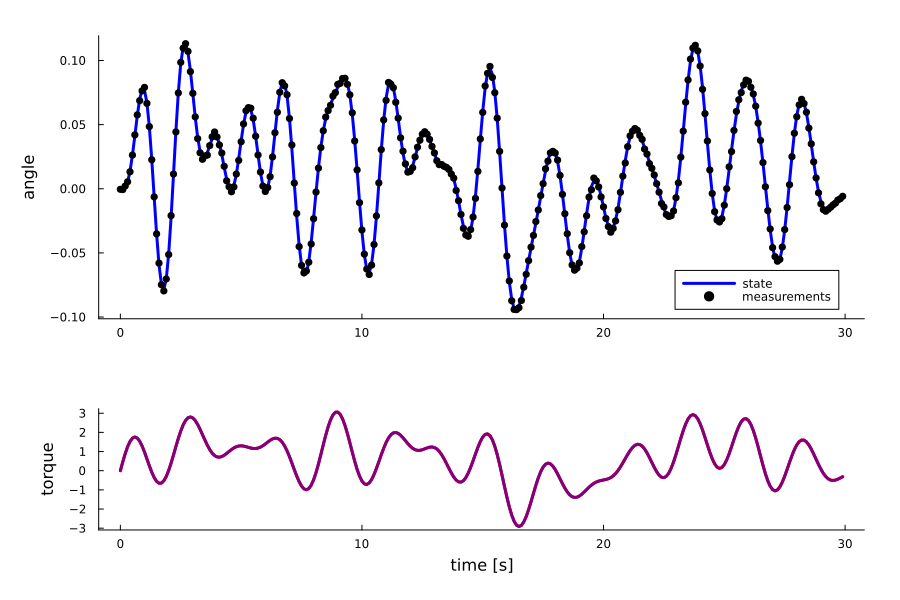

In [6]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Test model

In [7]:
# NARX settings
H = 1
Ly = 3
Lu = 3
M = size(ϕ(zeros(Ly+Lu), degree=H),1);

# Specify prior distributions
pτ0 = GammaShapeRate(1e3, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 10diagm(ones(M)))
goal = NormalMeanVariance(3.14, 1e-3)

T = 15
u_prior = 0.0
num_iters = 5

agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=u_prior,
                  num_iters=num_iters)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)
, GammaShapeRate{Float64}(a=1000.0, b=1.0), NormalMeanVariance{Float64}(μ=3.14, v=0.001), 15, 5, 0.0, 3, 3, 1, 7, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [8]:
py = []
qθ = [pθ0]
qτ = [pτ0]
FE = zeros(num_iters,N)

pp = Progress(N-T; showspeed=true)
for k in 1:(N-T)
    
    # Make predictions
    push!(py, predictions(agent, torques[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, observations[k], torques[k])
    push!(qθ, agent.qθ)
    push!(qτ, agent.qτ)
    
    # Evaluate
    FE[:,k] = agent.free_energy

    ProgressMeter.next!(pp)
end

Progress:   1%|▎                          |  ETA: 1:09:29 (14.73  s/it)

Progress: 100%|███████████████████████████| Time: 0:00:30 ( 0.11  s/it)


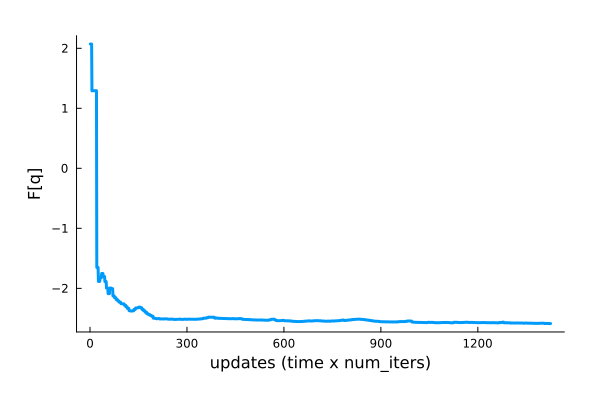

In [9]:
plot(reshape(FE[:,1:(N-T)], (num_iters*(N-T),)), xlabel="updates (time x num_iters)", ylabel="F[q]")

In [10]:
vθ = cat( var.(qθ)...,dims=2)
mθ = cat(mean.(qθ)...,dims=2)

7×286 Matrix{Float64}:
 0.0  -0.000412566  -0.000412684  -0.000414013  …   5.08838e-6    5.05726e-6
 0.0   0.0           4.87613e-7    2.40631e-6       1.08253       1.08253
 0.0   0.0           0.0          -5.90768e-6       0.276068      0.276054
 0.0   0.0           0.0           0.0             -0.686784     -0.686777
 0.0   0.0          -0.000542264  -0.000533349      0.000100129   0.000100504
 0.0   0.0           0.0           0.00656981   …   0.00137694    0.00137613
 0.0   0.0           0.0           0.0              0.00689255    0.00689298

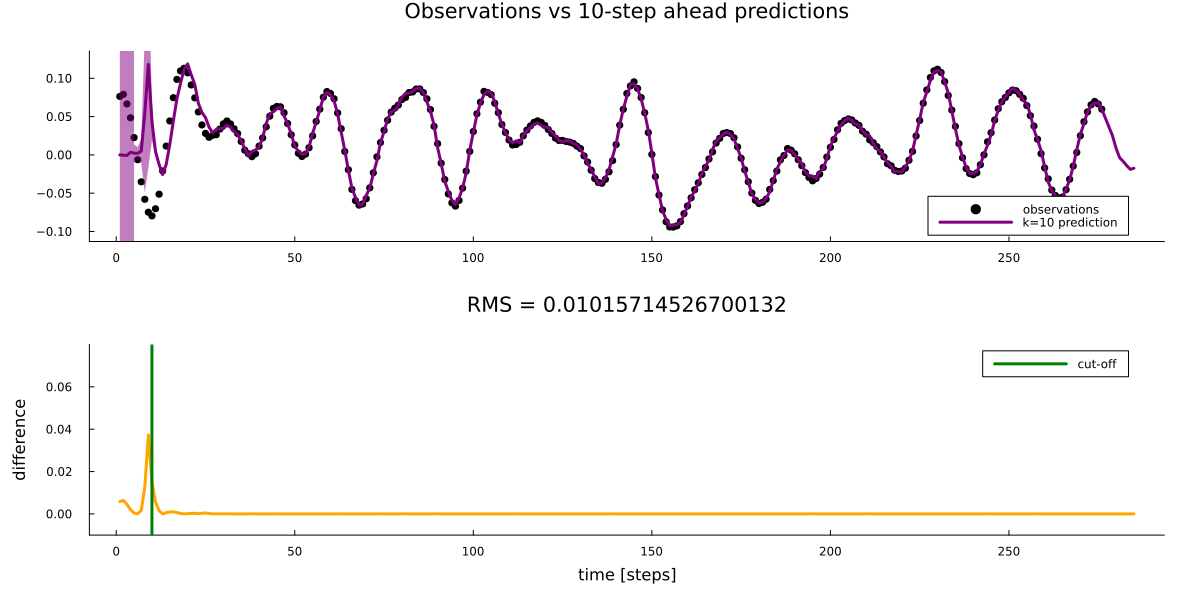

In [11]:
limsb = [minimum(observations)*1.2, maximum(observations)*1.2]
K = 10

residuals = (observations[K:K+(N-T)-1] .- [py[k][1][K] for k in 1:(N-T)]).^2
cutoff = 10
RMS = sqrt(mean((residuals[cutoff:end])))

p1 = plot(title="Observations vs $K-step ahead predictions", ylims=limsb)
scatter!(observations[K:N-T], color="black", label="observations")
plot!([py[k][1][K] for k in 1:(N-T)], ribbon=[py[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")
p2 = plot(xlabel="time [steps]", ylims=(-0.01, 0.08))
plot!(residuals, title="RMS = $RMS", color="orange", ylabel="difference")
vline!([cutoff], color="green", label="cut-off")
plot(p1,p2,layout=grid(2,1), size=(1200,600),)

## Experiments

In [12]:
# Experiment specification 
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 10

# System specification
init_state = [0.0, 0.0];

# Agent specification
pτ0 = GammaShapeRate(1e2, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 10diagm(ones(M)))
H = 1
Ly = 3
Lu = 3
M = size(ϕ(zeros(Ly+Lu), degree=H),1);
λ = 0.0
num_iters = 10

10

### Expected Free Energy minimization

In [13]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.00027912940028376125, 0.0, (-50.0, 50.0), 0.1, 2.0, 0.5, 0.2, 0.001)

In [14]:
T = 10
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goal, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=λ,
                  num_iters=num_iters)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)
, GammaShapeRate{Float64}(a=100.0, b=1.0), NormalMeanVariance{Float64}(μ=3.14, v=0.001), 10, 10, 0.0, 3, 3, 1, 7, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [15]:
function EFE(agent::NARXAgent, controls)
    "Expected Free Energy"

    μ = mean( agent.qθ)
    Σ = cov(  agent.qθ)
    α = shape(agent.qτ)
    β = rate( agent.qτ)

    ybuffer = agent.ybuffer
    ubuffer = agent.ubuffer
    
    J = 0
    for t in 1:agent.thorizon
        
        # Update control buffer
        ubuffer = backshift(ubuffer, controls[t])
        ϕ_k = ϕ([ybuffer; ubuffer], degree=agent.pol_degree)
        
        # Prediction
        m_y = dot(μ, ϕ_k)
        v_y = ϕ_k'*Σ*ϕ_k + β/α
        
        # Accumulate EFE
        # J += mutualinfo(agent, ϕ_k) + risk(agent, m_y,v_y) + agent.control_prior*controls[t]^2
        # J += risk(agent, m_y,v_y) + agent.control_prior*controls[t]^2
        J += mutualinfo(agent, ϕ_k)
        
        # Update previous 
        ybuffer = backshift(ybuffer, m_y)        
    end
    return J
end

opts = Optim.Options(time_limit=10.0, 
                     allow_f_increases=true, 
                     g_tol=1e-12, 
                     show_every=10,
                     iterations=10_000)

# Objective function
agent.goals = Any[NormalMeanVariance(3.14, 1e3) for k in 1:T]
J(u) = EFE(agent, u)

# Constrained minimization procedure
results = optimize(J, sys_ulims..., 1e-8*randn(T), Fminbox(LBFGS()), opts, autodiff=:forward)

 * Status: failure (exceeded time limit of 10.0)

 * Candidate solution
    Final objective value:     2.127421e-01

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.42e+02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.06e-05 ≰ 1.0e-12

 * Work counters
    Seconds run:   19  (vs limit 10)
    Iterations:    1
    f(x) calls:    11184
    ∇f(x) calls:   11184


In [16]:
pu_ = Optim.minimizer(results)

10-element Vector{Float64}:
  49.99999999978337
  49.99999999999999
  49.99921322233773
  49.99999999996952
  28.97926790758236
  40.945483327583275
 -49.99999999963227
  49.99999999999864
  36.99022440362313
  33.919815787005874

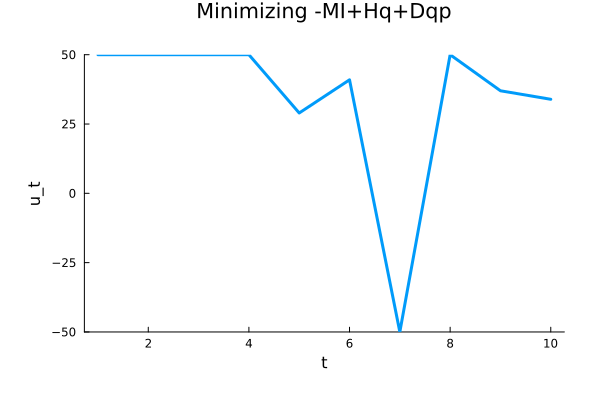

In [17]:
plot(pu_, ylims=sys_ulims, xlabel="t", ylabel="u_t", title="Minimizing -MI+Hq+Dqp")

In [18]:
savefig("figures/policy-mi+risk.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/info-seeking/figures/policy-mi+risk.png"

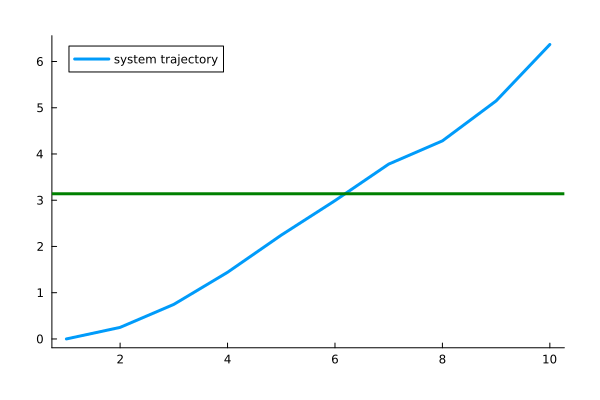

In [19]:
pendulum.state = [0.0, 0.]
sys_trajectory = sim_trajectory(pendulum, pu_)
plot(sys_trajectory[1,:], label="system trajectory")
hline!([mean(goal)], color="green")

In [20]:
agent = NARXAgent(pθ0, pτ0, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T)

NARXAgent(FactorGraphModel(), Constraints:
  marginals form:
  messages form:
  factorisation:
    q(θ, τ) = q(θ)q(τ)
Options:
  warn = true
, [Inf], MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)
, GammaShapeRate{Float64}(a=100.0, b=1.0), NormalMeanVariance{Float64}(μ=0.0, v=1.0), 10, 10, 0.0, 3, 3, 1, 7, [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [21]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T,
                  control_prior=λ,
                  num_iters=num_iters)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
pτ_EFE = [pτ0]
pθ_EFE = [pθ0]
pred_m = zeros(N,T)
pred_v = zeros(N,T)
F_EFE = zeros(num_iters, N)
goals = [NormalMeanVariance(3.14, Inf) for t in 1:T]
gvars = 10 .^range(3, stop=-3, length=N)
# gvars = [1e3 for k in 1:N]

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_EFE[k])
    z_EFE[:,k] = pendulum.state
    y_EFE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[:,k] = agent.free_energy
    push!(pθ_EFE, agent.qθ)
    push!(pτ_EFE, agent.qτ)

    # Move goal closer
    goal_k = NormalMeanVariance(3.14, gvars[k])
    update_goals!(goals, goal_k)
    agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

Progress:   2%|▉                                        |  ETA: 0:18:21

Progress:   3%|█▎                                       |  ETA: 0:13:25

Progress:   4%|█▋                                       |  ETA: 0:11:42

Progress:   5%|██                                       |  ETA: 0:10:10

Progress:   6%|██▌                                      |  ETA: 0:09:22

Progress:   7%|██▉                                      |  ETA: 0:08:51

Progress:   8%|███▎                                     |  ETA: 0:08:29

Progress:   9%|███▊                                     |  ETA: 0:07:59

Progress:  10%|████▏                                    |  ETA: 0:07:42

Progress:  11%|████▌                                    |  ETA: 0:07:23

Progress:  12%|████▉                                    |  ETA: 0:07:07

Progress:  13%|█████▍                                   |  ETA: 0:07:19

Progress:  14%|█████▊                                   |  ETA: 0:06:52

Progress:  15%|██████▏                                  |  ETA: 0:06:30

Progress:  16%|██████▌                                  |  ETA: 0:06:11

Progress:  17%|███████                                  |  ETA: 0:05:53

Progress:  18%|███████▍                                 |  ETA: 0:05:37

Progress:  19%|███████▊                                 |  ETA: 0:05:24

Progress:  20%|████████▎                                |  ETA: 0:05:10

Progress:  21%|████████▋                                |  ETA: 0:04:59

Progress:  22%|█████████                                |  ETA: 0:04:51

Progress:  23%|█████████▍                               |  ETA: 0:04:48

Progress:  24%|█████████▉                               |  ETA: 0:04:43

Progress:  25%|██████████▎                              |  ETA: 0:04:37

Progress:  26%|██████████▋                              |  ETA: 0:04:31

Progress:  27%|███████████▏                             |  ETA: 0:04:26

Progress:  28%|███████████▌                             |  ETA: 0:04:19

Progress:  29%|███████████▉                             |  ETA: 0:04:14

Progress:  30%|████████████▎                            |  ETA: 0:04:15

Progress:  31%|████████████▊                            |  ETA: 0:04:12

Progress:  32%|█████████████▏                           |  ETA: 0:04:13

Progress:  33%|█████████████▌                           |  ETA: 0:04:09

Progress:  34%|██████████████                           |  ETA: 0:04:08

Progress:  35%|██████████████▍                          |  ETA: 0:04:05

Progress:  36%|██████████████▊                          |  ETA: 0:04:03

Progress:  37%|███████████████▏                         |  ETA: 0:03:59

Progress:  38%|███████████████▋                         |  ETA: 0:03:56

Progress:  39%|████████████████                         |  ETA: 0:03:54

Progress:  40%|████████████████▍                        |  ETA: 0:03:49

Progress:  41%|████████████████▊                        |  ETA: 0:03:45

Progress:  42%|█████████████████▎                       |  ETA: 0:03:45

Progress:  43%|█████████████████▋                       |  ETA: 0:03:42

Progress:  44%|██████████████████                       |  ETA: 0:03:39

Progress:  45%|██████████████████▌                      |  ETA: 0:03:36

Progress:  46%|██████████████████▉                      |  ETA: 0:03:33

Progress:  47%|███████████████████▎                     |  ETA: 0:03:29

Progress:  48%|███████████████████▋                     |  ETA: 0:03:26

Progress:  49%|████████████████████▏                    |  ETA: 0:03:22

Progress:  50%|████████████████████▌                    |  ETA: 0:03:17

Progress:  51%|████████████████████▉                    |  ETA: 0:03:14

Progress:  52%|█████████████████████▍                   |  ETA: 0:03:10

Progress:  53%|█████████████████████▊                   |  ETA: 0:03:06

Progress:  54%|██████████████████████▏                  |  ETA: 0:03:03

Progress:  55%|██████████████████████▌                  |  ETA: 0:02:59

Progress:  56%|███████████████████████                  |  ETA: 0:02:55

Progress:  57%|███████████████████████▍                 |  ETA: 0:02:51

Progress:  58%|███████████████████████▊                 |  ETA: 0:02:47

Progress:  59%|████████████████████████▎                |  ETA: 0:02:42

Progress:  60%|████████████████████████▋                |  ETA: 0:02:37

Progress:  61%|█████████████████████████                |  ETA: 0:02:31

Progress:  62%|█████████████████████████▍               |  ETA: 0:02:25

Progress:  63%|█████████████████████████▉               |  ETA: 0:02:19

Progress:  64%|██████████████████████████▎              |  ETA: 0:02:13

Progress:  65%|██████████████████████████▋              |  ETA: 0:02:08

Progress:  66%|███████████████████████████              |  ETA: 0:02:03

Progress:  67%|███████████████████████████▌             |  ETA: 0:01:57

Progress:  68%|███████████████████████████▉             |  ETA: 0:01:52

Progress:  69%|████████████████████████████▎            |  ETA: 0:01:48

Progress:  70%|████████████████████████████▊            |  ETA: 0:01:43

Progress:  71%|█████████████████████████████▏           |  ETA: 0:01:38

Progress:  72%|█████████████████████████████▌           |  ETA: 0:01:34

Progress:  73%|█████████████████████████████▉           |  ETA: 0:01:29

Progress:  74%|██████████████████████████████▍          |  ETA: 0:01:25

Progress:  75%|██████████████████████████████▊          |  ETA: 0:01:21

Progress:  76%|███████████████████████████████▏         |  ETA: 0:01:17

Progress:  77%|███████████████████████████████▋         |  ETA: 0:01:13

Progress:  78%|████████████████████████████████         |  ETA: 0:01:09

Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:05

Progress:  80%|████████████████████████████████▊        |  ETA: 0:01:01

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:57

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:54

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:50

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:47

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:43

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:40

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:37

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:34

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:31

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:28

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:25

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:22

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:19

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:16

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:13

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:10

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:08

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:05

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:03

Progress: 100%|█████████████████████████████████████████| Time: 0:04:11


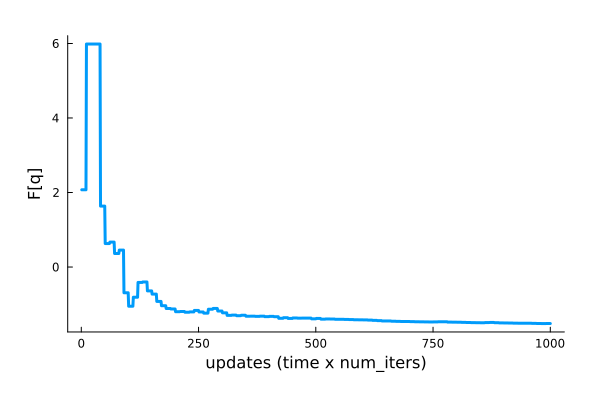

In [22]:
plot(F_EFE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

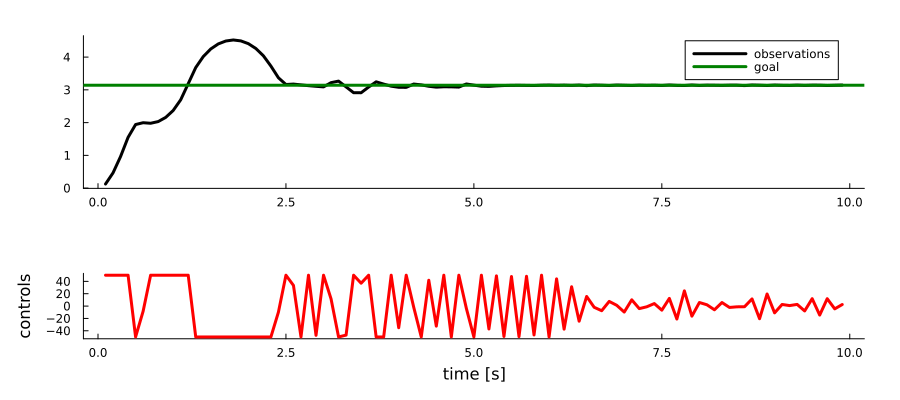

In [23]:
p1 = plot(tsteps[2:end], y_EFE[2:end], color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [24]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/info-seeking/figures/NARX-EFE-1Pendulum-trial.png"

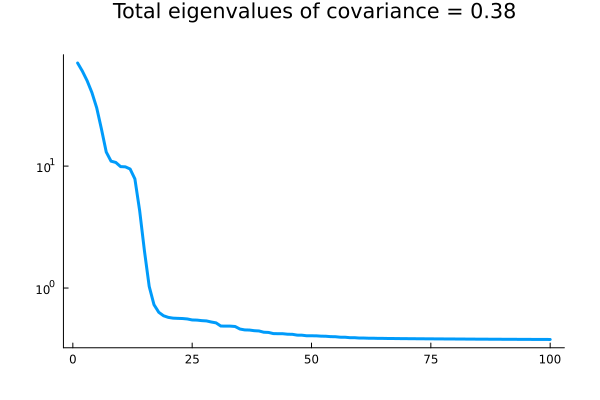

In [25]:
final_dSθ_EFE = round(sum(eigen(cov(pθ_EFE[end])).values), digits=2)
tSθ = [sum(eigen(cov(pθ_EFE[k])).values) for k in 1:N]
plot(tSθ, title="Total eigenvalues of covariance = $final_dSθ_EFE", yscale=:log10)

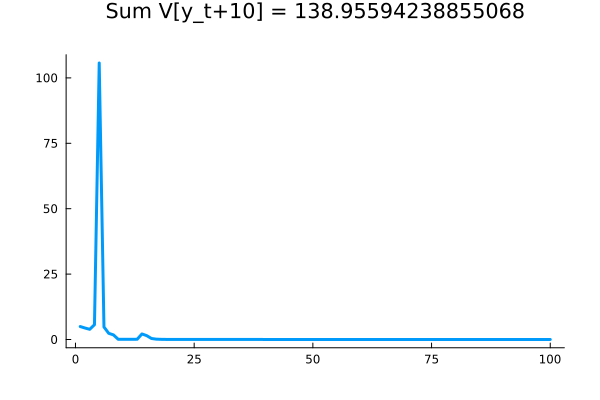

In [26]:
K = 10
sum_vy_k = sum(pred_v[:,K])
plot(pred_v[:,K], title="Sum V[y_t+$K] = $sum_vy_k")

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/info-seeking/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/info-seeking/figures/NARX-EFE-1Pendulum-planning.gif")
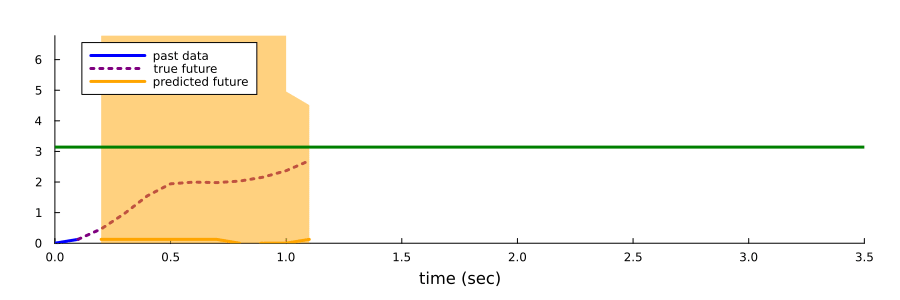

In [27]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

### Mean Squared Error minimization

In [29]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Set goal priors
goals = [NormalMeanVariance(3.14, 1.0) for t in 1:T]

# Start agent
agent = NARXAgent(pθ0, pτ0, 
                  goal_prior=goals,
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  thorizon=T)

# Preallocate
y_MSE = zeros(N)
z_MSE = zeros(2,N)
u_MSE = zeros(N+T)
pτ_MSE = [pτ0]
pθ_MSE = [pθ0]
pred_m = zeros(N,T)
pred_v = zeros(N,T)
F_MSE = zeros(num_iters, N)

@showprogress for k in 1:N
    
    # Act upon environment
    step!(pendulum, u_MSE[k])
    z_MSE[:,k] = pendulum.state
    y_MSE[k] = pendulum.sensor
    
    # Update parameter beliefs
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    F_MSE[:,k] = agent.free_energy
    push!(pθ_MSE, agent.qθ)
    push!(pτ_MSE, agent.qτ)
    
    # Optimal control
    policy = minimizeMSE(agent, goals, control_lims=sys_ulims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)
    
end

Progress:   2%|▉                                        |  ETA: 0:02:15

Progress:   5%|██                                       |  ETA: 0:00:56

Progress:   6%|██▌                                      |  ETA: 0:00:47

Progress:   8%|███▎                                     |  ETA: 0:00:37

Progress:   9%|███▊                                     |  ETA: 0:00:34

Progress:  10%|████▏                                    |  ETA: 0:00:31

Progress:  11%|████▌                                    |  ETA: 0:00:29

Progress:  12%|████▉                                    |  ETA: 0:00:27

Progress:  13%|█████▍                                   |  ETA: 0:00:26

Progress:  14%|█████▊                                   |  ETA: 0:00:24

Progress:  15%|██████▏                                  |  ETA: 0:00:23

Progress:  16%|██████▌                                  |  ETA: 0:00:22

Progress:  17%|███████                                  |  ETA: 0:00:21

Progress:  18%|███████▍                                 |  ETA: 0:00:20

Progress:  19%|███████▊                                 |  ETA: 0:00:20

Progress:  20%|████████▎                                |  ETA: 0:00:19

Progress:  21%|████████▋                                |  ETA: 0:00:18

Progress:  22%|█████████                                |  ETA: 0:00:18

Progress:  23%|█████████▍                               |  ETA: 0:00:17

Progress:  25%|██████████▎                              |  ETA: 0:00:16

Progress:  26%|██████████▋                              |  ETA: 0:00:15

Progress:  27%|███████████▏                             |  ETA: 0:00:15

Progress:  28%|███████████▌                             |  ETA: 0:00:14

Progress:  29%|███████████▉                             |  ETA: 0:00:14

Progress:  30%|████████████▎                            |  ETA: 0:00:14

Progress:  31%|████████████▊                            |  ETA: 0:00:13

Progress:  32%|█████████████▏                           |  ETA: 0:00:13

Progress:  33%|█████████████▌                           |  ETA: 0:00:13

Progress:  34%|██████████████                           |  ETA: 0:00:12

Progress:  35%|██████████████▍                          |  ETA: 0:00:12

Progress:  36%|██████████████▊                          |  ETA: 0:00:12

Progress:  37%|███████████████▏                         |  ETA: 0:00:11

Progress:  38%|███████████████▋                         |  ETA: 0:00:11

Progress:  39%|████████████████                         |  ETA: 0:00:11

Progress:  40%|████████████████▍                        |  ETA: 0:00:11

Progress:  41%|████████████████▊                        |  ETA: 0:00:10

Progress:  42%|█████████████████▎                       |  ETA: 0:00:10

Progress:  43%|█████████████████▋                       |  ETA: 0:00:10

Progress:  44%|██████████████████                       |  ETA: 0:00:10

Progress:  45%|██████████████████▌                      |  ETA: 0:00:09

Progress:  46%|██████████████████▉                      |  ETA: 0:00:09

Progress:  47%|███████████████████▎                     |  ETA: 0:00:09

Progress:  48%|███████████████████▋                     |  ETA: 0:00:09

Progress:  49%|████████████████████▏                    |  ETA: 0:00:09

Progress:  50%|████████████████████▌                    |  ETA: 0:00:08

Progress:  51%|████████████████████▉                    |  ETA: 0:00:08

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:08

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:08

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:08

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:07

Progress:  56%|███████████████████████                  |  ETA: 0:00:07

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:07

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:07

Progress:  59%|████████████████████████▎                |  ETA: 0:00:07

Progress:  60%|████████████████████████▋                |  ETA: 0:00:07

Progress:  61%|█████████████████████████                |  ETA: 0:00:06

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:06

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:06

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:06

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:06

Progress:  66%|███████████████████████████              |  ETA: 0:00:06

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:06

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:05

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:05

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:05

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:05

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:05

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:05

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:04

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:04

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:04

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:04

Progress:  78%|████████████████████████████████         |  ETA: 0:00:04

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:04

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:03

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:03

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:03

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:03

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:03

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:03

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:02

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:02

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:02

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:02

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:02

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:02

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:01

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:01

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:01

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


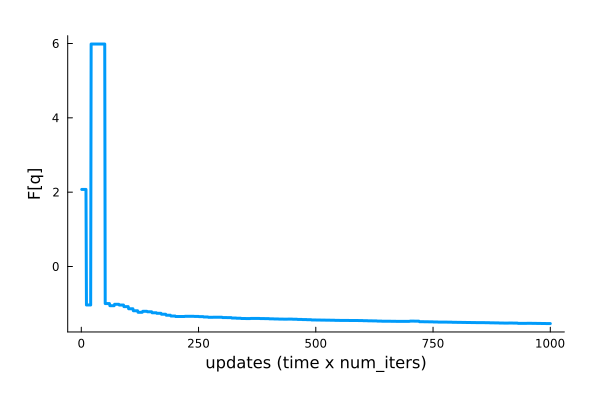

In [30]:
plot(F_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

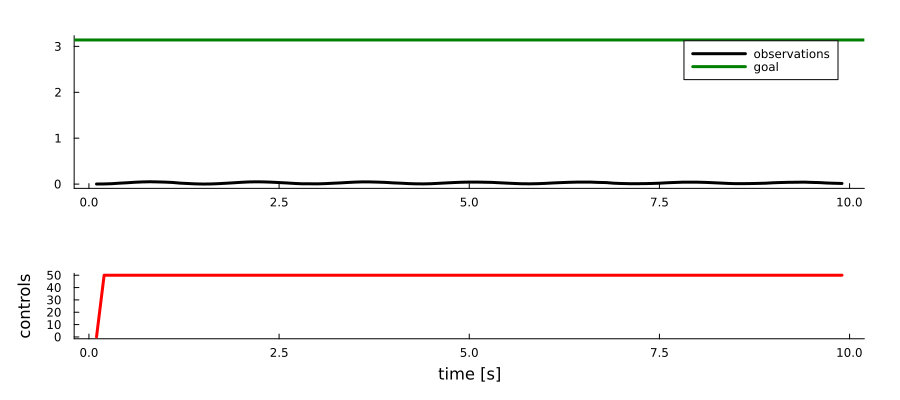

In [31]:
p1 = plot(tsteps[2:end], y_MSE[2:end], color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(tsteps[2:end], u_MSE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [32]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/info-seeking/figures/NARX-MSE-1Pendulum-trial.png"

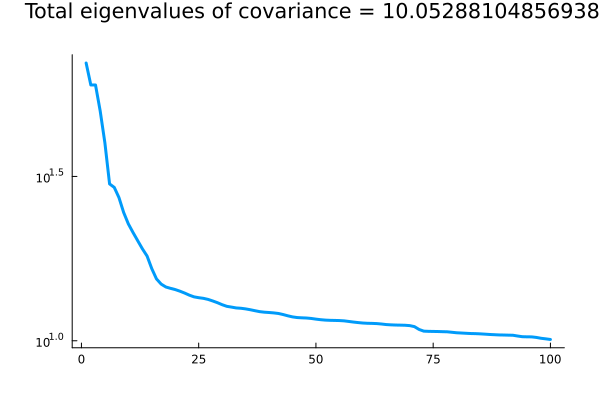

In [33]:
final_dSθ_MSE = sum(eigen(cov(pθ_MSE[end])).values)
tSθ = [sum(eigen(cov(pθ_MSE[k])).values) for k in 1:N]
plot(tSθ, title="Total eigenvalues of covariance = $final_dSθ_MSE", yscale=:log10)

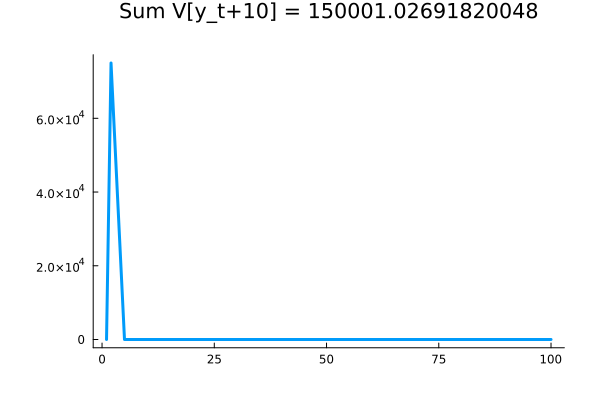

In [34]:
K = 10
sum_vy_k = sum(pred_v[:,K])
plot(pred_v[:,K], title="Sum V[y_t+$K] = $sum_vy_k")

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/info-seeking/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/info-seeking/figures/NARX-MSE-1Pendulum-planning.gif")
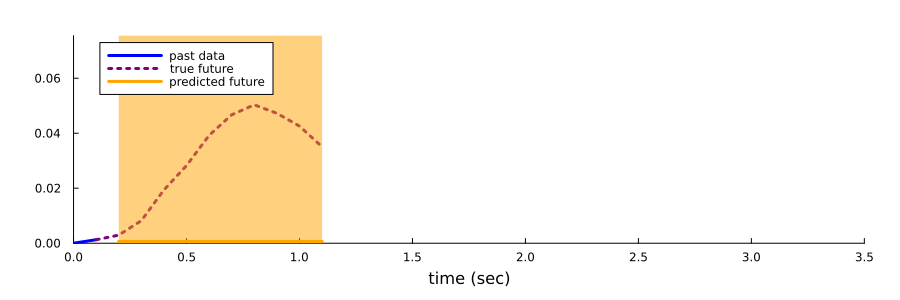

In [35]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)

### Comparisons

In [36]:
println("Final sum of eigenvalues of Σ_θ for MSE = $final_dSθ_MSE")
println("Final sum of eigenvalues of Σ_θ for EFE = $final_dSθ_EFE")

Final sum of eigenvalues of Σ_θ for MSE = 10.052881048569386
Final sum of eigenvalues of Σ_θ for EFE = 0.38


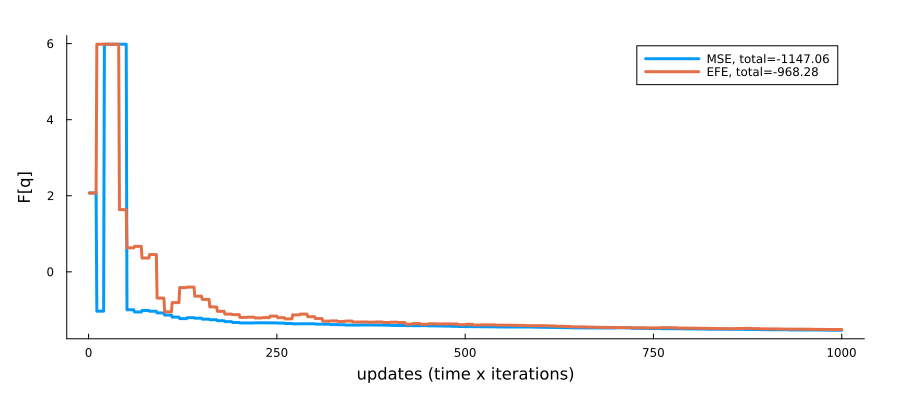

In [37]:
sF_MSE = round(sum(F_MSE[:]), digits=2)
sF_EFE = round(sum(F_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(F_MSE[:], label="MSE, total=$sF_MSE")
plot!(F_EFE[:], label="EFE, total=$sF_EFE")

In [38]:
# evidence_MSE = [-logpdf(py_MSE[k][1], y_MSE[k+1]) for k in 1:(N-1)]
# evidence_EFE = [-logpdf(py_EFE[k][1], y_EFE[k+1]) for k in 1:(N-1)]

# total_evidence_MSE = round(sum(evidence_MSE), digits=2)
# total_evidence_EFE = round(sum(evidence_EFE), digits=2)

# plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
# plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
# plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

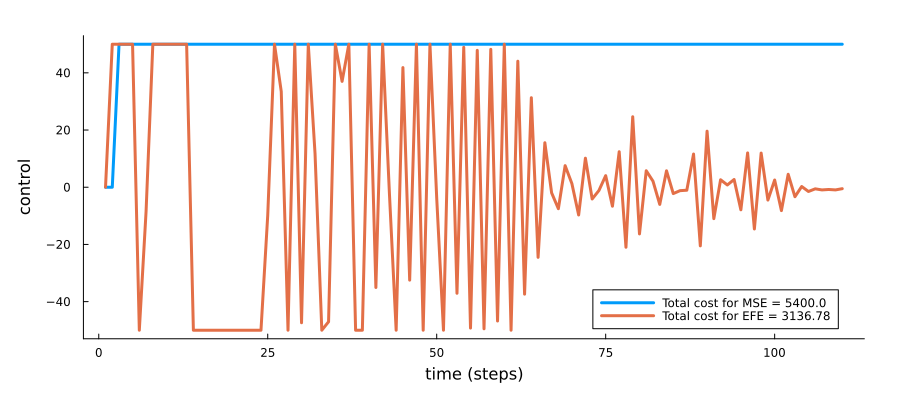

In [39]:
CC_MSE = round(sum(abs.(u_MSE)), digits=2)
CC_EFE = round(sum(abs.(u_EFE)), digits=2)

plot(xlabel="time (steps)", ylabel="control", size=(900,400))
plot!(u_MSE, label="Total cost for MSE = $CC_MSE")
plot!(u_EFE, label="Total cost for EFE = $CC_EFE")

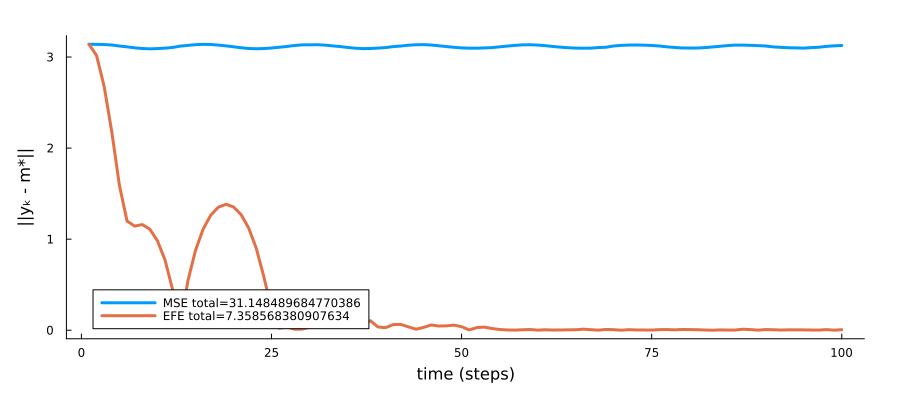

In [40]:
J_MSE = [norm(y_MSE[k] - mean(goal),2) for k in 1:N]
J_EFE = [norm(y_EFE[k] - mean(goal),2) for k in 1:N]

sJ_MSE = norm(y_MSE .- mean(goal),2)
sJ_EFE = norm(y_EFE .- mean(goal),2)

plot(xlabel="time (steps)", ylabel="||yₖ - m*||", size=(900,400))
plot!(J_MSE, label="MSE total=$sJ_MSE")
plot!(J_EFE, label="EFE total=$sJ_EFE")